<a href="https://colab.research.google.com/github/VladimirVladetic/OSiRV-RoadSignDetection/blob/main/EDA_Training_Testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import numpy as np
import pandas as pd
import os
import cv2
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input, BatchNormalization
from PIL import Image
from keras.preprocessing.image import load_img, img_to_array
import zipfile
from keras.utils import to_categorical
from tensorflow.keras.regularizers import l1_l2, l1, l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.models import save_model, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img
import shutil
from imblearn.under_sampling import RandomUnderSampler
import xml.etree.ElementTree as ET
import pybboxes as pbx
from collections import defaultdict
from google.colab import files

In [3]:
! pip install kaggle

In [2]:
! pip install pybboxes

In [5]:
uploaded = files.upload()

source_path = '/content/kaggle.json'
destination_path = '/root/.kaggle/kaggle.json'
kaggle_dir = '/root/.kaggle/'
if not os.path.exists(kaggle_dir):
    os.makedirs(kaggle_dir)
os.rename(source_path, destination_path)

Saving kaggle.json to kaggle.json


In [6]:
! kaggle datasets download -d andrewmvd/road-sign-detection

 99% 215M/218M [00:10<00:00, 25.7MB/s]
100% 218M/218M [00:10<00:00, 21.2MB/s]


In [7]:
with zipfile.ZipFile('/content/road-sign-detection.zip', 'r') as zip_ref:
  zip_ref.extractall('/content')

In [8]:
annotations_path = '/content/annotations'
annotations = os.listdir(annotations_path)

In [ ]:
print(annotations)
print(len(annotations))

In [11]:
img_name_list = []
width_list = []
height_list = []
label_list = []
xmin_list = []
ymin_list = []
xmax_list = []
ymax_list = []

for idx in tqdm(range(len(annotations))):

    tree = ET.parse(os.path.join(annotations_path, annotations[idx]))
    root = tree.getroot()

    img_name = root.find('filename').text

    size = root.find('size')
    width = size.find('width').text
    height = size.find('height').text

    for group in root.findall('object'):
        label = group.find('name').text
        bbox = group.find('bndbox')
        xmin = bbox.find('xmin').text
        ymin = bbox.find('ymin').text
        xmax = bbox.find('xmax').text
        ymax = bbox.find('ymax').text

        img_name_list.append("/content/images/" + img_name)
        width_list.append(width)
        height_list.append(height)
        xmin_list.append(xmin)
        ymin_list.append(ymin)
        xmax_list.append(xmax)
        ymax_list.append(ymax)
        label_list.append(label)

  0%|          | 0/877 [00:00<?, ?it/s]

In [16]:
df = pd.DataFrame({
                        'image_path': img_name_list,
                        'width': width_list,
                        'height': height_list,
                        'xmin': xmin_list,
                        'ymin': ymin_list,
                        'xmax': xmax_list,
                        'ymax': ymax_list,
                        'class_label': label_list})

classes = df['class_label'].unique().tolist()
classes

df['class_int'] = df['class_label'].apply(lambda x: classes.index(x))
df.head()

,image_path,width,height,xmin,ymin,xmax,ymax,class_label,class_int
0,/content/images/road297.png,300,400,221,176,252,211,speedlimit,0
1,/content/images/road455.png,300,400,164,184,199,221,speedlimit,0
2,/content/images/road875.png,300,400,50,248,61,261,speedlimit,0
3,/content/images/road875.png,300,400,105,141,160,194,speedlimit,0
4,/content/images/road875.png,300,400,164,267,178,284,stop,1


In [36]:
import imgaug.augmenters as iaa
import numpy as np
import cv2
import pandas as pd
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage

# Function to apply data augmentation to images and bounding boxes
def augment_data(images, annotations):
    # Convert DataFrame columns to a NumPy array representing bounding boxes
    annotations = annotations[['xmin', 'ymin', 'xmax', 'ymax']].to_numpy()

    # Define augmentation pipeline
    seq = iaa.Sequential([
        iaa.Fliplr(0.5),  # horizontal flips
        iaa.Affine(
            rotate=(-10, 10),  # random rotations
            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},  # random scaling
            translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}  # random translation
        )
    ])

    # Initialize lists to store augmented images and annotations
    augmented_images = []
    augmented_annotations = []

    for image, annotation in zip(images, annotations):
        # Convert bounding box coordinates to imgaug BoundingBox format
        bbs = [BoundingBox(x1=annotation[i], y1=annotation[i+1], x2=annotation[i+2], y2=annotation[i+3])
               for i in range(0, len(annotation), 4)]

        # Apply augmentation to image and bounding boxes
        augmented_image, augmented_bbs = seq(image=image, bounding_boxes=bbs)

        # Append augmented image and bounding boxes to lists
        augmented_images.append(augmented_image)
        augmented_annotations.append(augmented_bbs)

    return augmented_images, augmented_annotations

# Load images and annotations from the DataFrame
images = [cv2.imread(image_path) for image_path in df['image_path']]
annotations = df[['xmin', 'ymin', 'xmax', 'ymax']]
annotations[['xmin', 'ymin', 'xmax', 'ymax']] = annotations[['xmin', 'ymin', 'xmax', 'ymax']].astype(float)



# Perform data augmentation
augmented_images, augmented_annotations = augment_data(images, annotations)

# Convert augmented images and annotations to NumPy arrays
max_boxes = max(len(bb_list) for bb_list in augmented_annotations)

# Pad all bounding box lists to have the same length
padded_annotations = [bb_list + [BoundingBox(0, 0, 0, 0)] * (max_boxes - len(bb_list)) for bb_list in augmented_annotations]

# Convert the lists of bounding boxes to a 3D NumPy array
augmented_annotations = np.array(padded_annotations)

image_dimensions = 224
fixed_size = (image_dimensions, image_dimensions)

# Resize all augmented images to the fixed size
augmented_images_resized = [cv2.resize(image, fixed_size) for image in augmented_images]

# Convert the resized images into a NumPy array
augmented_images = np.array(augmented_images_resized)

In [31]:
print(augmented_annotations)
print(len(augmented_annotations))
print(len(augmented_images))

[[BoundingBox(x1=243.4297, y1=129.1779, x2=273.3265, y2=166.4765, label=None)]
 [BoundingBox(x1=107.5803, y1=229.6346, x2=142.6995, y2=262.8337, label=None)]
 [BoundingBox(x1=130.9779, y1=206.5676, x2=142.2955, y2=222.6618, label=None)]
 ...
 [BoundingBox(x1=99.3101, y1=182.4487, x2=122.6362, y2=200.5557, label=None)]
 [BoundingBox(x1=240.1981, y1=172.1211, x2=263.3880, y2=196.9427, label=None)]
 [BoundingBox(x1=56.4513, y1=181.4816, x2=80.7961, y2=202.0041, label=None)]]
1244
1244


In [46]:
features = extract_features_edge(augmented_images,image_dimensions,image_dimensions)

  0%|          | 0/1244 [00:00<?, ?it/s]

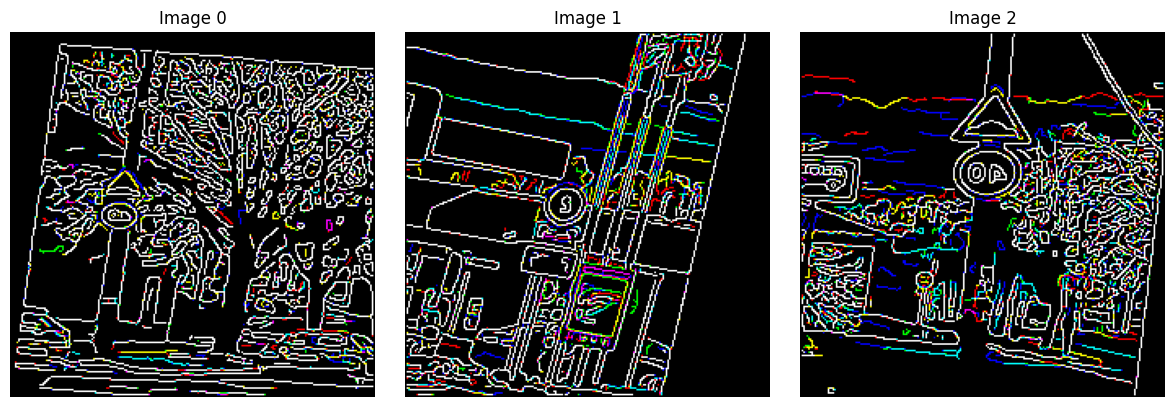

In [47]:
import matplotlib.pyplot as plt
indices_to_display = [0, 1, 2]
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for i, idx in enumerate(indices_to_display):
    image = features[idx]
    axes[i].imshow(image)
    axes[i].set_title(f'Image {idx}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Generate region proposals using RPN
proposals = generate_proposals(features)

# Perform ROI pooling
roi_features = roi_pooling(features, proposals)

# Train R-CNN model
rcnn_model = build_rcnn_model()
rcnn_model.compile(optimizer='adam', loss=['categorical_crossentropy', 'smooth_l1'])

rcnn_model.fit(roi_features, [augmented_annotations['class_int'], augmented_annotations[['xmin', 'ymin', 'xmax', 'ymax']]])

# After training, use the model for inference
predictions = rcnn_model.predict(test_images)

In [41]:
from skimage import feature

def extract_features_edge(images, height, width):
    features = []
    for var_img  in tqdm(images):
        edge_channels = [feature.canny(var_img[:, :, i]) for i in range(3)]
        edges = np.stack(edge_channels, axis=-1)
        edges_image = Image.fromarray(edges.astype(np.uint8) * 255)
        edges_image = edges_image.resize((height, width), Image.ANTIALIAS)
        edges_image = np.array(edges_image)
        edges_image = edges_image / 255.0
        features.append(edges_image)

    features = np.array(features)
    features = features.reshape(len(features), height, width, 3)
    features = np.array(features, dtype=np.float64)
    return features

In [38]:
from PIL import ImageOps

def extract_features_contrast(images, height, width):
    features = []
    for image in tqdm(images):
        var_img = Image.fromarray(image, mode='RGB')
        var_img = ImageOps.equalize(var_img, mask=None) ## Contrast enhancement
        var_img = var_img.resize((height,width), Image.ANTIALIAS)
        var_img = np.array(var_img)
        var_img = var_img / 255.0
        features.append(var_img)
    features = np.array(features)
    features = features.reshape(len(features), height, width, 3)
    features = np.array(features, dtype=np.float64)
    return features

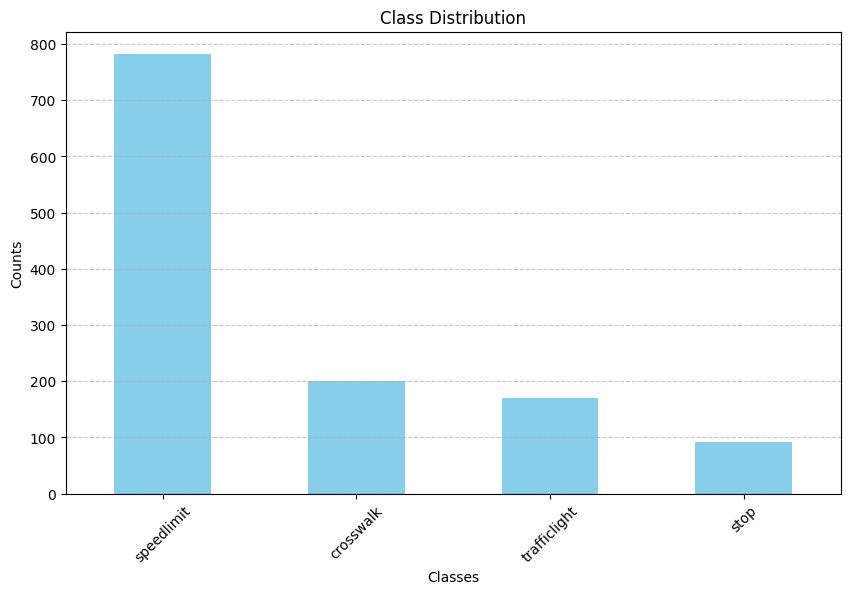

In [ ]:
class_counts = df['class_label'].value_counts()

plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar', color='skyblue')
plt.title('Class Distribution')
plt.xlabel('Classes')
plt.ylabel('Counts')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
plt.figure(figsize=(8, 6))
plt.hist(df['width'], bins=30, color='purple', edgecolor='black')
plt.title('Distribution of Image Width')
plt.xlabel('Width')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

plt.figure(figsize=(8, 6))
plt.hist(df['height'], bins=30, color='red', edgecolor='black')
plt.title('Distribution of Image Height')
plt.xlabel('Height')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()